In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from scipy.optimize import curve_fit,fsolve
from copy import copy
%matplotlib inline

Import Some Data

In [2]:
with open('asu.tsv','r') as f:
    lines = [line for line in f.readlines() if '#' not in line]
data_lines = [line.strip().split('\t') for line in lines if 'HD' in line]
rv_star=[]
rv_data=np.zeros((1,2))
for line in data_lines:
    rv_star.append(' '.join(line[2].strip().split()))
    temp= np.array([float(line[-2].strip()),float(line[-1].strip())])
    rv_data = np.vstack((rv_data,temp))
rv_data= rv_data[1:,:]
unique_stars = np.unique(rv_star)
rv_star = np.array(rv_star)
print unique_stars

['HD 10002' 'HD 100180' 'HD 100623' 'HD 10086' 'HD 101177' 'HD 101259'
 'HD 10126' 'HD 10145' 'HD 101501' 'HD 102158' 'HD 102634' 'HD 102870'
 'HD 103095' 'HD 103432' 'HD 103932' 'HD 104067' 'HD 10436' 'HD 104526'
 'HD 104556' 'HD 10476' 'HD 104800' 'HD 105113' 'HD 105405' 'HD 105590'
 'HD 105618' 'HD 105631' 'HD 106116' 'HD 106156' 'HD 10697' 'HD 10700'
 'HD 107148' 'HD 107705' 'HD 10780' 'HD 108510' 'HD 108874' 'HD 109358'
 'HD 11020' 'HD 110315' 'HD 110537' 'HD 111031' 'HD 111066' 'HD 111398'
 'HD 111484' 'HD 111484B' 'HD 111515' 'HD 111631' 'HD 112257' 'HD 11226'
 'HD 114174' 'HD 114710' 'HD 114729' 'HD 114783' 'HD 114946' 'HD 11505'
 'HD 115383' 'HD 115589' 'HD 115617' 'HD 116442' 'HD 116443' 'HD 117207'
 'HD 117936' 'HD 118914' 'HD 11964' 'HD 119850' 'HD 120066' 'HD 120467'
 'HD 120476' 'HD 12051' 'HD 121560' 'HD 122064' 'HD 122120' 'HD 122303'
 'HD 12235' 'HD 122652' 'HD 124106' 'HD 12414' 'HD 124292' 'HD 124642'
 'HD 124694' 'HD 125184' 'HD 125455' 'HD 126053' 'HD 12661' 'HD 12

In [3]:
with open('data.dat','r') as f:
    lines = [line for line in f.readlines() if '#' not in line]
data_lines = [line.strip().split('\t') for line in lines if 'HD' in line]
rv_data=np.zeros((1,3))
rv_star=[]
stellar_data={}
for line in data_lines:
    if len(line) > 4:
        # Stellar params
        stellar_data[line[0].strip()] = float(line[2].strip())        
    else:
        rv_star.append(line[0].strip())
        temp = np.array([float(lin.strip()) for lin in line[1:]])

        rv_data = np.vstack((rv_data,temp))

rv_data = rv_data[1:,:]
unique_stars = np.unique(rv_star)
rv_star = np.array(rv_star)
print unique_stars

['HD 177830' 'HD 218566' 'HD 31253' 'HD 74156' 'HD 99492']


In [9]:
for name in unique_stars:
    mass = stellar_data[name]
    ind = rv_star == name
    header='# {} Mass {:.3f}(0) Jitter 0'.format(name,mass)
    lines = [header]
    for line in rv_data[ind,:]:
        lines.append('\t'.join(line.astype(str)))
    
    with open(name+'.dat','w') as f:
        f.write('\n'.join(lines))
    print name


HD 177830
HD 218566
HD 31253
HD 74156
HD 99492


# Orbit Equation
The velocity of the star along the line of sight due to a planet on an elliptical orbit is,
 <br />
 
 $ V_r = K_1 \left\{ \cos(\omega + f) + e \cos(\omega) \right\}$,
 
Where the $K_1$ parameter gives us the semi-amplitude of the velocity,
<br />
$ K_1 = 28.4329 \,\frac{m}{s} \, \frac{1}{\sqrt{1-e^2}} \left( \frac{M \sin i}{M_J} \right) 
\left( \frac{M_\star}{M_\odot} \right)^{-2/3} \left( \frac{P}{1 \, yr} \right)^{-1/3}$
<br />
$ K_1 = 203.244 \,\frac{m}{s} \, \frac{1}{\sqrt{1-e^2}} \left( \frac{M \sin i}{M_J} \right) 
\left( \frac{M_\star}{M_\odot} \right)^{-2/3} \left( \frac{P}{1 \, day} \right)^{-1/3}$
<br />  
$K_1$ depends on the planet mass, $M\sin i$, the eccentricity, $e$, the semi-major axis, $a$, and the stellar mass, $M_\star$. We get $M_\star$ by independent measurements of the star, so we're left with three parameters to fit for in $K_1$. 

We'll fit the velocity data to a generic sine wave.
<br/>
$V_r = a \left[ \cos( b t + c ) + d \right)$
<br/>
We can then relate these parameters to the orbit parameters.
<br/>
$ \cos(\omega) = c $
<br/>
$ e = d/c $
<br/>
$p = 2 \pi / b$
<br /> 
$ K_1 = a$
<br />
We can then calculate $M \sin i$ from the expression for $K_1$.

In [2]:
G = 4*np.pi**2 /(356.25)**2 # G in AU^3/(day^2 Solar Mass)

def solve_kep_eqn(l,e):
    """ Solve Keplers equation u - e*sin(u) = l for u"""
    try:
        l[0]
        res = np.zeros(l.shape)
        for i,li in enumerate(l):
            tmp,= fsolve(lambda x: x-e*np.sin(x) - li,li)
            res[i] = tmp
    except IndexError:
        res, = fsolve(lambda x: x - e*np.sin(x)-l,l)
   
    return res

def get_best_n(t,vr):
    periods = 10**np.linspace(-3,4,1000)
    omega = 2*np.pi/periods
    res=sig.lombscargle(t-t[0],vr,omega)
    max_pers = np.argsort(res)
    return omega[max_pers[-1]],periods,res

def vr_func(t,n,tau,k,w,d):
    """Obtain the radial velocity due to a single planet.
    t = time of measurement,
    n = period of planet,
    tau = time of pericenter passage,
    k = amplitude of radial velocity (depends on planet mass and eccentricity),
    w = related to the argument of pericenter by a shift of pi.
    d = D.C offset, 
    The radial velocity at time t is given by
    vr = k*(cos(f + w)+d), where f is related to the number of periods since pericenter passage, n*(t-tau)"""
    e = d/np.cos(w)
    u = solve_kep_eqn(n*(t-tau),e)
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(u*.5),np.sqrt(1-e)*np.cos(u*.5))

    return k*(np.cos(f+w)+d)

def fitting_func(n):
    def vr_func_n(t,tau,k,w,d):
        """Obtain the radial velocity due to a single planet.
        t = time of measurement,
        n = period of planet,
        tau = time of pericenter passage,
        k = amplitude of radial velocity (depends on planet mass and eccentricity),
        w = related to the argument of pericenter by a shift of pi.
        d = D.C offset, 
        The radial velocity at time t is given by
        vr = k*(cos(f + w)+d), where f is related to the number of periods since pericenter passage, n*(t-tau)"""
        e = d/np.cos(w)
        u = solve_kep_eqn(n*(t-tau),e)
        f = 2*np.arctan2(np.sqrt(1+e)*np.sin(u*.5),np.sqrt(1-e)*np.cos(u*.5))

        return k*(np.cos(f+w)+d)
    return vr_func_n

def recover_params(mstar,n,tau,k,w,d):
    """Recover the masses of the planets"""
    e = d/np.cos(w)
    k1 = (G*n)**(1./3) * (1 - e**2)**(-1./2)
    mass_f = k/k1
    # Now make assumption that most of the mass is in the star
    mp = mass_f * mstar**(2./3) # Planet mass in solar masses
    mp *= 9.543e-4
    p = 2*np.pi/n
    a = (G*mstar/n**2)**(1./3)
    return np.abs(mp),np.abs(e),p,a

def plot_data(t,vr,vr_err,n,popt,pcov,pers,periodogram_res):
    t_fit = np.linspace(t[0],t[-1],1e3)
    vr_fit = np.array([vr_func(x,n,*popt) for x in t_fit])
    resids = vr - np.array([vr_func(x,n,*popt) for x in t])
    
    fig = plt.figure(figsize=(12,10))
    ax=fig.add_axes((.1,.3,.8,.6))
    ax.errorbar(t,vr,yerr=vr_err,fmt='o')
    ax.plot(t_fit,vr_fit)
    ax.set_xticklabels([]) #Remove x-tic labels for the first frame
    ax.grid()

#Residual plot
    axr=fig.add_axes((.1,.1,.8,.2))        
    axr.errorbar(t,resids,yerr=vr_err,fmt='o')
    axr.axhline(0,color='k',linewidth=2)
#axr.plot(t_lin,ff(t_lin,*popt2))
    axr.grid()

    axp=fig.add_axes(((.91,.3,.6,.6)))
    axp.semilogx(pers,periodogram_res)
    axp.axvline(2*np.pi/n,linestyle='--',color='k',linewidth=3)
    
    n_r,pers_r,periodo_r = get_best_n(t,resids)
    axpr=fig.add_axes(((.91,.1,.6,.2)))
    axpr.semilogx(pers_r,periodo_r)
    axpr.axvline(2*np.pi/n_r,linestyle='--',color='k',linewidth=3)
    
#     plt.errorbar(t,vr,yerr=vr_err,fmt='o')
#     plt.plot(t_fit,vr_fit)

def fit_data(t,vr,vr_err,mstar,star_name):
    n,pers,periodogram_res = get_best_n(t,vr)
    popt,pcov = curve_fit(fitting_func(n),t,vr,sigma=vr_err,absolute_sigma=True,p0=(t[0],vr.max(),0,.1))
    popterr = np.sqrt(np.diag(pcov))
    popt_str_vals = []
    for p1,p2 in zip(popt,popterr):
        popt_str_vals.append(p1)
        popt_str_vals.append(p2)
    print 'Error in cosine fit:'
    print 'tau=%.2e pm %.2e\nK = %.2e pm %.2e\nomega = %.2e pm %.2e\nd = %.2e pm %.2e'% tuple(popt_str_vals)
    mp,e,p,a = recover_params(mstar,n,*popt)
    print '\n\n',star_name
    print 'Mp: >%.3f Mj\ne: %.3f\nPeriod: %.3f days\na: %.3f AU'  %(mp,e,p,a)
    plot_data(t,vr,vr_err,n,popt,pcov,pers,periodogram_res)
    return

def fit_it(name,t,vr,vr_err,units='m/s'):
    periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),1000)
    omega = 2*np.pi/periods
    res=sig.lombscargle(t-t[0],vr,omega)
    max_pers = np.argsort(res)
    best_omega = omega[max_pers[-1]]
    best_per = 2*np.pi/best_omega
    def recover_params(ms,a,c,d,units='m/s'):
        fac=1
        norm = 203.244
        if units == 'km/s':
            fac = 1e-3
        p = best_per #abs(2*np.pi/b)
        e = np.abs(d/np.cos(c))
        k1 = fac*norm/np.sqrt(1-e**2) * ms**(-2./3) * p**(-1./3)
        mp = abs(a/k1)
        return mp,e,p
    def uncertainties(func, xvals, params, pcov):
        ymed = func(xvals,*params)
        dx = np.sqrt(np.diag(pcov,0))
        dfdx = np.zeros((len(params),len(xvals)))
        for i,pv in enumerate(params):
            pp = copy(params)
            pm = copy(pp)
            pp[i] += dx[i]
            pm[i] -= dx[i]
            dfdx[i,:] = (func(xvals,*pp) - func(xvals,*pm))/(2*dx[i])
        dy = np.zeros(xvals.shape)
        for i in range(len(xvals)):
            dy[i] = np.sqrt(np.dot(dfdx[:,i],np.dot(pcov,dfdx[:,i])))
        return dy
        
    ff = lambda x,a,c,d:a*(np.cos(best_omega*x+c)+d)
    popt,pcov=curve_fit(ff, t-t[0],vr,sigma=vr_err,absolute_sigma=True,p0=(vr.max(),0,0))
    mp,e,p=recover_params(stellar_data[name],*popt)
    t_fit = np.linspace(t[0],t[-1],1e3)
    v_fit = ff(t_fit-t[0],*popt)
    v_fit_err = uncertainties(ff,t_fit,popt,pcov)
    print name
    print 'Mp: >%.3f Mj\ne: %.3f\nPeriod: %.3f days\na: %.3f AU'  %(mp,e,p,(p/365.25)**(2./3))
    print popt
    print popt[0]*np.cos(popt[1]),popt[0]*np.sin(popt[1])*-1,popt[2]
    return mp,e,p,t_fit,v_fit,v_fit_err
def fit_it2(name,t,vr,vr_err,units='m/s'):
    periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),1000)
    omega = 2*np.pi/periods
    res=sig.lombscargle(t-t[0],vr,omega)
    max_pers = np.argsort(res)
    best_omega = omega[max_pers[-1]]
    best_per = 2*np.pi/best_omega
    def recover_params2(ms,a,b,c,units='m/s'):
        fac=1
        norm = 203.244
        if units == 'km/s':
            fac = 1e-3
        p = best_per #abs(2*np.pi/b)
        ap = np.sqrt(a**2 + b**2)
        bp = np.arctan2(-b,a)
        e = np.abs(c/(a/ap))
        k1 = fac*norm/np.sqrt(1-e**2) * ms**(-2./3) * p**(-1./3)
        mp = abs(ap/k1)
        return mp,e,p

    ff = lambda x,a,b,c:a*(np.cos(best_omega*x)+b*np.sin(best_omega*x)+c)
    popt,pcov=curve_fit(ff, t-t[0],vr,sigma=vr_err,absolute_sigma=True,p0=(vr.max(),0,0))

    mp,e,p=recover_params2(stellar_data[name],*popt)
    t_fit = np.linspace(t[0],t[-1],1e3)
    v_fit = ff(t_fit-t[0],*popt)
    print name
    print 'Mp: >%.3f Mj\ne: %.3f\nPeriod: %.3f days\na: %.3f AU'  %(mp,e,p,(p/365.25)**(2./3))
    print popt
    return mp,e,p,t_fit,v_fit
def plot_it(name,mass,t,vr,vr_err,t_fit,v_fit,v_fit_err,units='m/s'):
    periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),100)
    omega = 2*np.pi/periods
    res=sig.lombscargle(t-t[0],vr,omega)
    max_pers = np.argsort(res)
    best_per = 2*np.pi/omega[max_pers[-1]]
    fig,axes=plt.subplots(1,2,figsize=(12,4))
    axes[1].semilogx(2*np.pi/omega,res)
    axes[1].axvline(best_per,color='k',linestyle='--',linewidth=2)
    axes[1].axvline(p,color='r',linestyle='--',linewidth=2)
    axes[1].set_xlabel('Period')
    axes[1].set_title('Periodogram')
    axes[0].errorbar(t,vr,yerr=vr_err,fmt='o')
    axes[0].plot(t_fit,v_fit,'-m')
    axes[0].fill_between(t_fit,v_fit-v_fit_err,v_fit+v_fit_err,alpha=1,edgecolor='#3F7F4C',facecolor='#7EFF99')
    axes[0].set_xlabel('Julian Day')
    axes[0].set_ylabel('Radial Velocity ' + units)
    axes[0].set_title(unique_stars[i] + '\t$M_\star$ = %.3f $M_\odot$'%mass)
    for ax in axes:
        ax.minorticks_on()
    

(0.016444031655541962, 0.0, 10.0, 0.09236272793321257)
(0.015686606425562678, 0.29999999999999999, 10.0, 0.09236272793321257)
(0.013155225324433572, 0.59999999999999998, 10.0, 0.09236272793321257)
(0.0071677872210891246, 0.90000000000000002, 10.0, 0.09236272793321257)


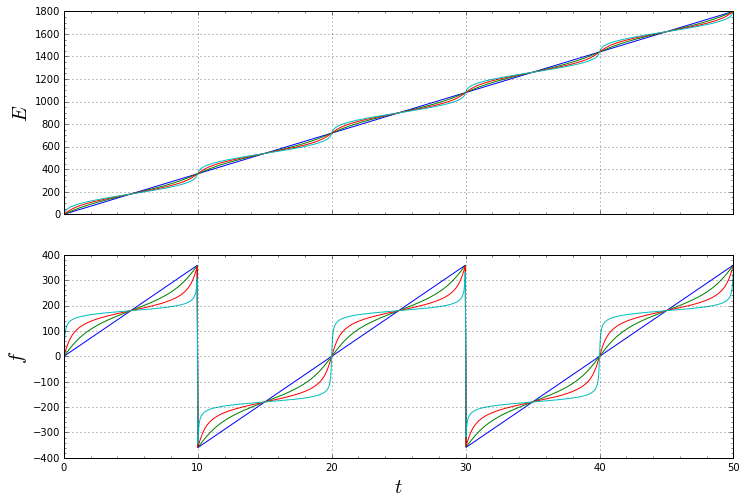

In [28]:
x=np.linspace(0,50,1e3)
w = 0
n = 2*np.pi/10
tau = 0
k = 1
fig,axes=plt.subplots(2,1,sharex=True,figsize=(12,8))
axes[0].set_ylabel('$E$',fontsize=20)
axes[1].set_ylabel('$f$',fontsize=20)
#axes[2].set_ylabel('$v_r$',fontsize=20)
axes[1].set_xlabel('$t$',fontsize=20)
for e in [0,.3,.6,.9]:
    print recover_params(1.,n,tau,k,w,e*np.cos(w))
    uvals = solve_kep_eqn(n*(x-tau),e)
    fvals = 2*np.arctan2(np.sqrt(1+e)*np.sin(uvals/2),np.sqrt(1-e)*np.cos(uvals/2))
    vrvals = k*(np.cos(fvals + w) + e*np.cos(w))
    axes[1].plot(x,fvals*180/np.pi)
    axes[0].plot(x,uvals*180/np.pi)
#    axes[2].plot(x,vrvals)
for ax in axes:
    ax.minorticks_on()
    ax.grid()
fig.savefig('keplers_eqn.svg')

Error in cosine fit:
tau=2.45e+06 pm 8.62e+00
K = -3.08e+01 pm 1.46e-01
omega = -1.51e+00 pm 1.36e-01
d = 2.07e-03 pm 4.66e-03


HD 177830
Mp: >2.241 Mj
e: 0.034
Period: 403.279 days
a: 1.235 AU


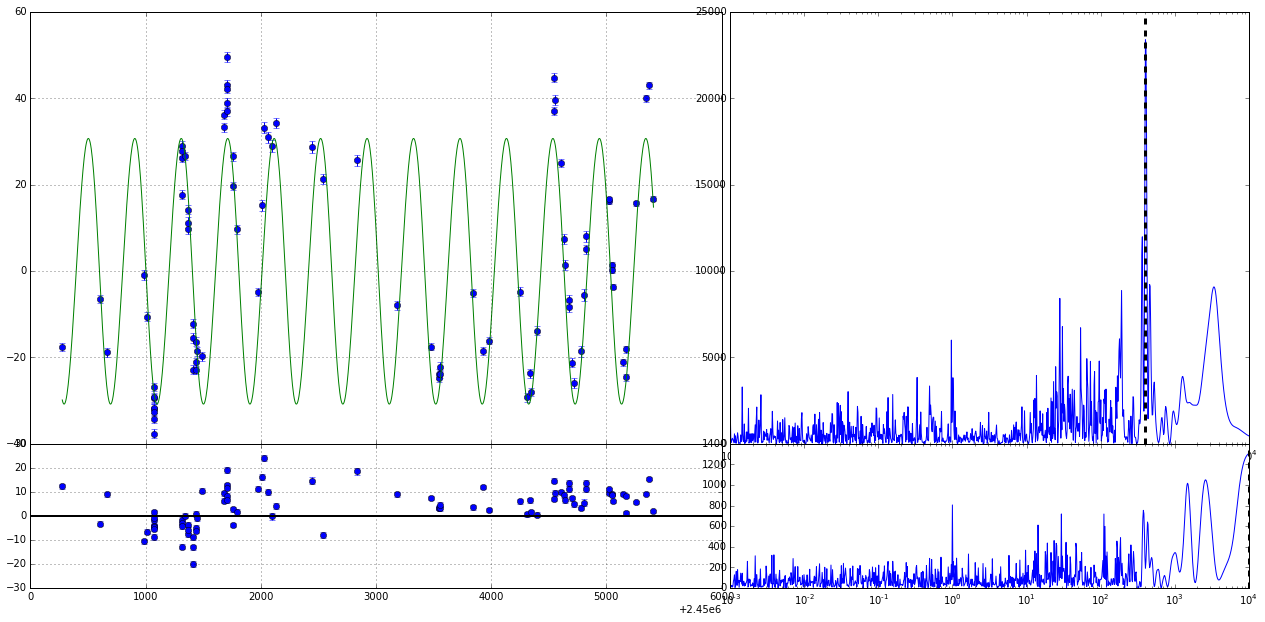

In [9]:
i = 0
name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]
#print v_fit_err
fit_data(t,vr,vr_err,mass,name)




HD 177830
Mp: >1.505 Mj
e: 0.185
Period: 405.184 days
a: 1.072 AU
[-32.53731624   0.04442572  -0.18462273]
-32.5052129733 1.4450183191 -0.184622728907


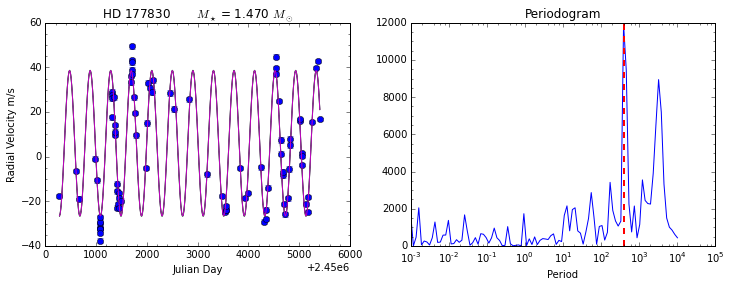

In [7]:
i = 0
name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]
#print v_fit_err
mp,e,p,t_fit,v_fit,v_fit_err=fit_it(name,t,vr,vr_err)
plot_it(name,mass,t,vr,vr_err,t_fit,v_fit,v_fit_err)




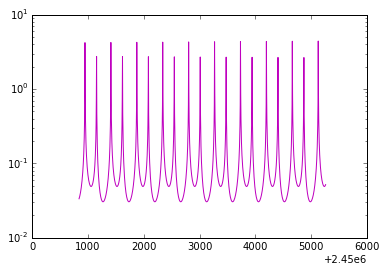

In [96]:
#plt.fill_between(t_fit,v_fit-v_fit_err,v_fit+v_fit_err)
plt.semilogy(t_fit,np.abs(v_fit_err/v_fit),'-m')

HD 74156
Mp: >4.905 Mj
e: 0.360
Period: 2633.847 days
a: 3.733 AU
[ 67.0201416   -0.98327932  -0.35954037]


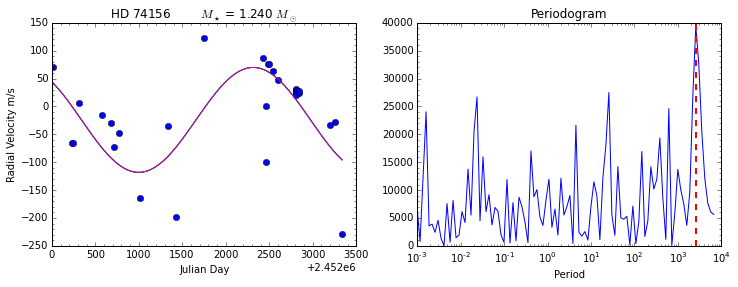

In [101]:
i = 3
name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]

mp,e,p,t_fit,v_fit=fit_it2(name,t,vr,vr_err)
plot_it(name,mass,t,vr,vr_err,t_fit,v_fit,np.zeros(v_fit.shape))



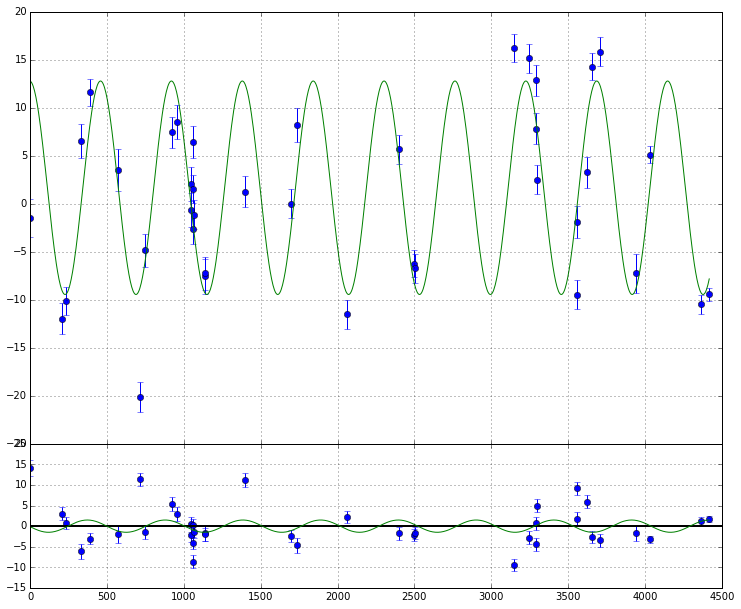

In [17]:
i = 2

name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]

periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),100)
omega = 2*np.pi/periods
res=sig.lombscargle(t-t[0],vr,omega)
max_pers = np.argsort(res)
best_per = 2*np.pi/omega[max_pers[-1]]
second_per = 2*np.pi/omega[max_pers[-2]]

phase = np.mod(t-t[0],best_per)*2*np.pi/best_per

vr_ord = vr[np.argsort(phase)]
vr_err_ord = vr[np.argsort(phase)]
phase_ord = phase[np.argsort(phase)]



ff = lambda x,a,b,c,d:a*(np.cos(b*x+c)+d)

popt,pcov=curve_fit(ff, t-t[0],vr,sigma=vr_err,absolute_sigma=True,p0=(vr.max(),2*np.pi/best_per,0,0))

resids = ff(t-t[0],*popt) - vr

popt2,pcov2=curve_fit(ff, t-t[0],resids,sigma=vr_err,absolute_sigma=True,p0=(resids.max(),2*np.pi/best_per,0,0))

resids2 = ff(t-t[0],*popt2) - resids

t_lin = np.linspace(0,t[-1]-t[0],1e3)

fig = plt.figure(figsize=(12,10))
ax=fig.add_axes((.1,.3,.8,.6))
ax.errorbar(t-t[0],vr,yerr=vr_err,fmt='o')
ax.plot(t_lin,ff(t_lin,*popt))

ax.set_xticklabels([]) #Remove x-tic labels for the first frame
ax.grid()

#Residual plot
axr=fig.add_axes((.1,.1,.8,.2))        
axr.errorbar(t-t[0],ff(t-t[0],*popt) - vr,yerr=vr_err,fmt='o')
axr.axhline(0,color='k',linewidth=2)
axr.plot(t_lin,ff(t_lin,*popt2))
axr.grid()


HD 31253
Mp: >nan Mj
e: 8.096
Period: 482.377 days
a: 1.204 AU
[  2.53550533e+06   8.05213791e+00   1.07933986e+03   1.63046041e+00]
0.0345459606923


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in sqrt


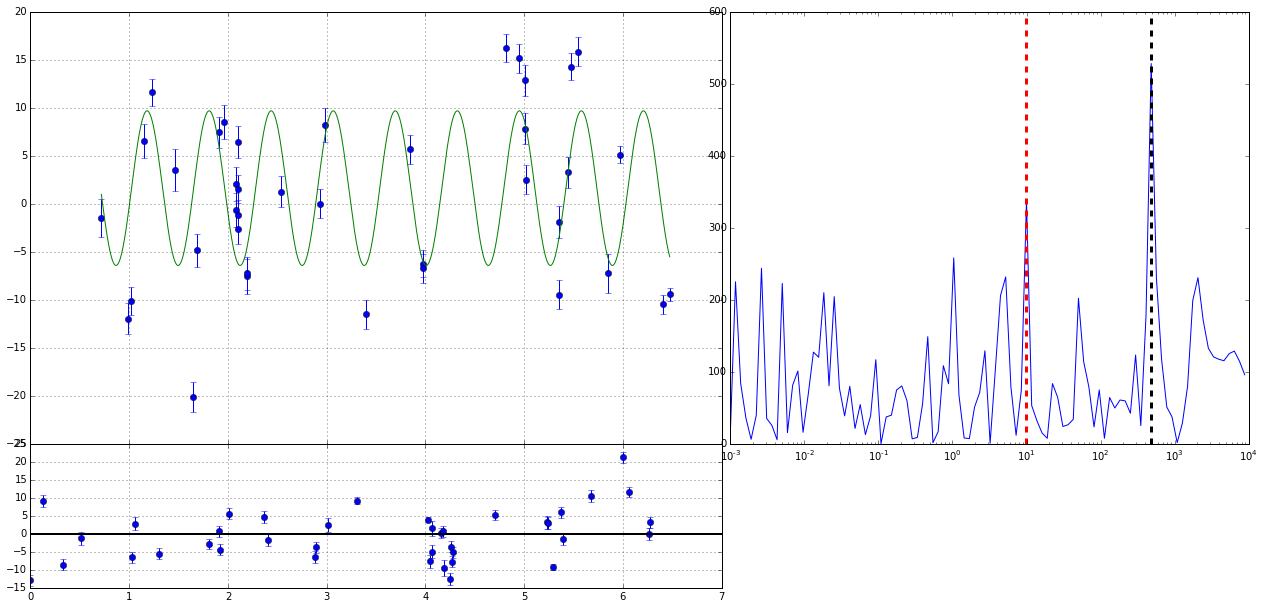

In [22]:
i = 2

name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]

periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),100)
omega = 2*np.pi/periods
res=sig.lombscargle(t-t[0],vr,omega)
max_pers = np.argsort(res)
best_per = 2*np.pi/omega[max_pers[-1]]
second_per = 2*np.pi/omega[max_pers[-2]]

phase = np.mod(t-t[0],best_per)*2*np.pi/best_per

vr_ord = vr[np.argsort(phase)]
vr_err_ord = vr[np.argsort(phase)]
phase_ord = phase[np.argsort(phase)]

def phase_fold(x,p0,per):
    x = (x-p0)/per
#    x = x - np.floor(x)
    return x*2*np.pi

def phase_fold_fit(x,p0,a,b,c):
#    x = phase_fold(x,p0,best_per)
    
#    x = np.mod(x-p0,2*np.pi/best_per)
    return a*np.cos((x-p0)*2*np.pi/best_per + b)+c

ff = lambda x,a,c,d:a*np.cos(x+c)+d
ff2 = lambda x,a,c,d:a*(np.cos(x*2*np.pi/second_per+c)+d)


phase = np.mod(t-t[vr==vr.max()],best_per)*2*np.pi/best_per

popt,pcov=curve_fit(phase_fold_fit, t ,vr, sigma=vr_err, absolute_sigma=True,p0=(t[len(t)/2],vr.max(),0,0))
norm = 203.244      
p = best_per
e = np.abs(popt[3]/np.cos(popt[2]))
k1 = norm/np.sqrt(1-e**2) * mass**(-2./3) * p**(-1./3)
mp = abs(popt[1]/k1)

print '%s\nMp: >%.3f Mj\ne: %.3f\nPeriod: %.3f days\na: %.3f AU'  %(name,mp,e,p,(p/365.25)**(2./3))

print popt
print (popt[0]-t[0])/t[0]
resids =phase_fold_fit(t,*popt) - vr
#phase = np.mod(t-popt[0],2*np.pi/best_per)
#popt2,pcov2=curve_fit(ff, t-t[0],resids,sigma=vr_err,absolute_sigma=True,p0=(resids.max(),2*np.pi/best_per,0,0))

#resids2 = ff(t-t[0],*popt2) - resids

t_lin = np.linspace(t[0],t[-1],1e3)
p_lin = phase_fold(t_lin,popt[0],p)
#t_lin = np.linspace(t[0],t[-1],1e3)
vr_fit = phase_fold_fit(t_lin,*popt)

fig = plt.figure(figsize=(12,10))
ax=fig.add_axes((.1,.3,.8,.6))
ax.errorbar(phase_fold(t,popt[0],p),vr,yerr=vr_err,fmt='o')
ax.plot(p_lin,vr_fit)

ax.set_xticklabels([]) #Remove x-tic labels for the first frame
ax.grid()

#Residual plot
axr=fig.add_axes((.1,.1,.8,.2))        
axr.errorbar(phase,resids,yerr=vr_err,fmt='o')
axr.axhline(0,color='k',linewidth=2)
#axr.plot(t_lin,ff(t_lin,*popt2))
axr.grid()

axp=fig.add_axes(((.91,.3,.6,.6)))
axp.semilogx(periods,res)
axp.axvline(best_per,linestyle='--',color='k',linewidth=3)
axp.axvline(second_per,linestyle='--',color='r',linewidth=3)

In [8]:
plt.errorbarv,vr,yerr=vr_err,fmt='o')

SyntaxError: invalid syntax (<ipython-input-8-aed753734cd2>, line 1)

In [18]:
with open('hd75784.dat','r') as f:
    lines = f.readlines()
    wlines = []
    for line in lines:
        if '#' in line:
            wlines.append(line.strip())
        else:
            if len(line.strip().split('\t')) == 3:
                wlines.append(line.strip())
            else:
                wlines.append('\t'.join(line.strip().split('\t')[:-1]))
with open('hd75784.dat','w') as f:
    f.write('\n'.join(wlines))